# EDA&INSIGHT - 6610401993 ฐาพล ชินกรสกุล

## 1. Import สิ่งที่จำเป็น

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
from sklearn.utils import shuffle
import seaborn as sns

C:\Users\sunmodza\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. ตั้งค่าการทดลอง

### 2.1 ตั้ง seed เพื่อให้การทดลอง reproducible

In [2]:
np.random.seed(42)
random_state = 42

### 2.2 ตั้งค่านัยสำคัญไว้ก่อนที่จะทดลอง

In [3]:
ALPHA = 0.05

## 3. โหลดชุดข้อมูลเป้าหมาย

In [4]:
df_insight = pd.read_pickle("cleaned_6610401993.pkl")

In [5]:
df_insight.columns

Index(['adult', 'budget', 'genres', 'homepage', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'movie_id',
       'collection_name', 'movies_before', 'collection_count',
       'main_cast_gender', 'main_cast_character', 'main_cast_name',
       'movie_after', 'roi', 'keywords', 'vote_after',
       'next_main_cast_gender_same', 'next_main_cast_actor_name_same',
       'next_main_cast_same', 'vote_increase'],
      dtype='object')

## 4. กรองข้อมูล เลือกข้อมูล และสร้าง Feature เพื่อการวิเคราะห์

### 4.1 กรองข้อมูลให้เหลือเฉพาะที่เกี่ยวข้อง
- ลบข้อมูลหนังที่ไม่มีภาคต่อ (เราวิเคราะห์เฉพาะที่มีภาคต่อ)
- จำกัดสูงสุด 5 เรื่องต่อ collection (เพื่อไม่ให้เกิดการซ้ำซ้อนของ keyword ที่จะทำให้การวิเคราะห์ผิดพลาด)
- ลบค่าสุดโต่ง
- ลบ row ที่มีค่าที่สนใจได้แก่ "vote_increase", "vote_after" (เราไม่สามารถวิเคราะห์อันที่ไม่มีได้)
- ลบ keyword ที่แม้พบบ่อยแต่ก็ไม่มีความหมาย ได้แก่ 'sequel', 'duringcreditsstinger', 'aftercreditsstinger'

In [6]:
df_insight = df_insight[df_insight["movie_after"]!=0.0]
df_insight = df_insight.groupby("collection_name").head(5)
df_insight = df_insight.replace([np.inf, -np.inf], np.nan)
df_insight = df_insight.dropna(subset=["vote_increase", "vote_after"])
df_insight.shape

(2459, 38)

In [7]:
all_keywords = []
for keywords in df_insight['keywords'].dropna():
    all_keywords.extend(keywords)
unique_keywords = list(set(all_keywords))

if 'sequel' in unique_keywords:
    unique_keywords.remove('sequel')
if 'duringcreditsstinger' in unique_keywords:
    unique_keywords.remove('duringcreditsstinger')
if 'aftercreditsstinger' in unique_keywords:
    unique_keywords.remove('aftercreditsstinger')

def keyword_to_onehot(keywords_list, unique_keywords):
    if isinstance(keywords_list, list):
        return {f"keyword_{keyword}": 1 if keyword in keywords_list else 0 for keyword in unique_keywords}
    else:
        return {f"keyword_{keyword}": 0 for keyword in unique_keywords}

keyword_dummies = df_insight['keywords'].apply(
    lambda x: keyword_to_onehot(x, unique_keywords)
)

keyword_df = pd.DataFrame(keyword_dummies.tolist(), index=df_insight.index)

df_insight = pd.concat([df_insight, keyword_df], axis=1)

### 4.2 สกัดเฉพาะ Column ที่สนใจ

In [8]:
interested = df_insight.drop(["movie_id","vote_after","roi","genres","keywords"],axis=1)

## 5. สำรวจความสัมพันธ์ในข้อมูล

### 5.1 วิเคราะห์ความสัมพันธ์ระหว่างภาพยนตร์ที่มีตัวละครเหมือนกันกับที่ไม่เหมือนกัน

#### 5.1.1 แสดง Visualization ของความสัมพันธ์ระหว่างภาพยนตร์ที่มีตัวละครเหมือนกันกับที่ไม่เหมือนกัน

-0.018979878583000626


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


-0.0461138858560842


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


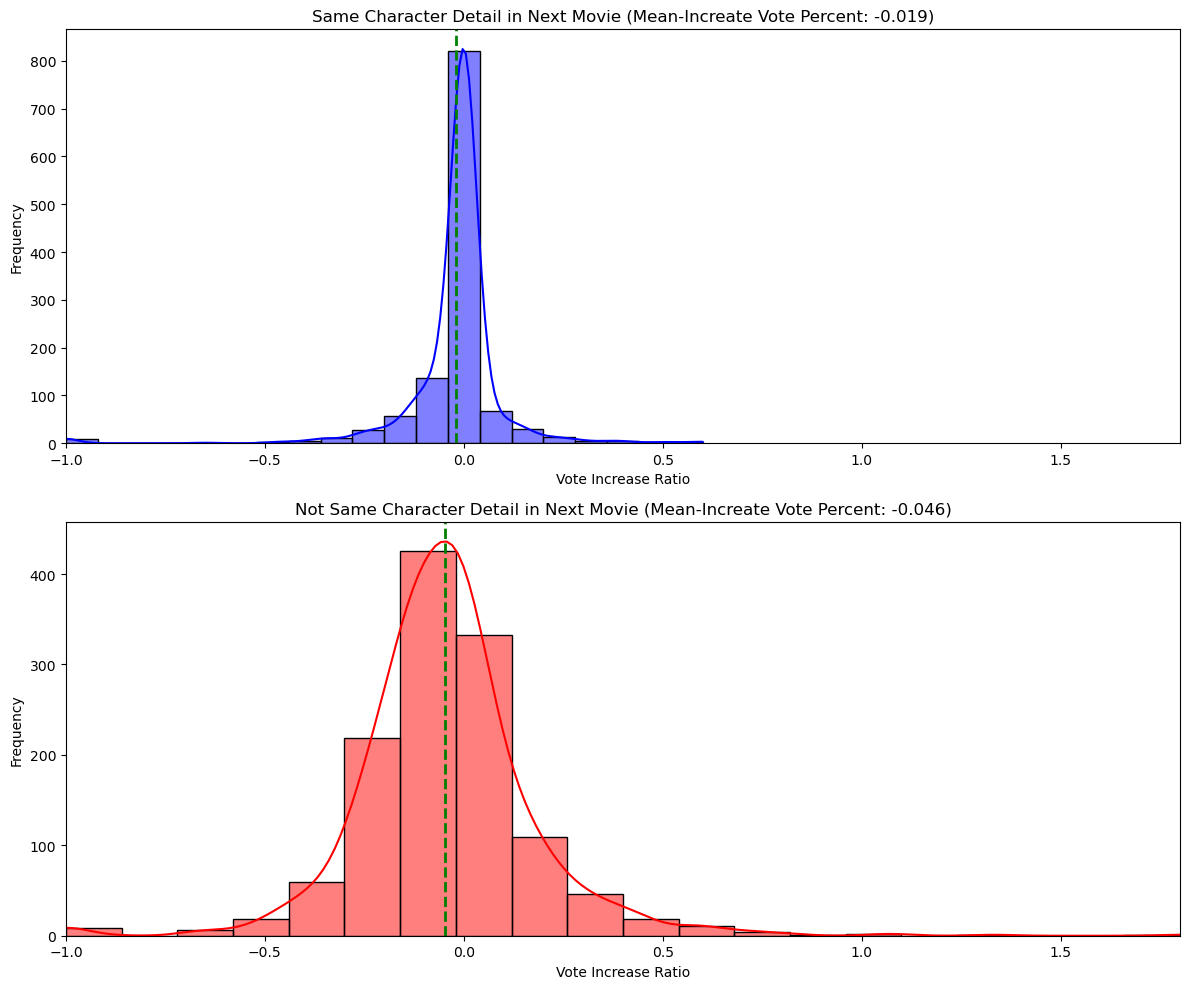

In [9]:
ptr = df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)==3]["vote_increase"]
print(ptr.mean())
# Find global min and max for consistent x-axis limits
min_val = df_insight['vote_increase'].min()
max_val = df_insight['vote_increase'].max()

fig, axes = plt.subplots(2, 1, figsize=(12,10))

sns.histplot(data=ptr, kde=True, ax=axes[0], bins=20, color='blue')
axes[0].axvline(ptr.mean(), color='green', linestyle='--', linewidth=2)
axes[0].set_title(f'Same Character Detail in Next Movie (Mean-Increate Vote Percent: {ptr.mean():.3f})')
axes[0].set_xlabel('Vote Increase Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(min_val, max_val)


ptr = df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)!=3]["vote_increase"]
print(ptr.mean())
sns.histplot(data=ptr, kde=True, ax=axes[1], bins=20, color='red')
axes[1].axvline(ptr.mean(), color='green', linestyle='--', linewidth=2)
axes[1].set_title(f'Not Same Character Detail in Next Movie (Mean-Increate Vote Percent: {ptr.mean():.3f})')
axes[1].set_xlabel('Vote Increase Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(min_val, max_val)

plt.tight_layout()
plt.show()

#### 5.1.2 แสดงตารางของความสัมพันธ์ระหว่างภาพยนตร์ที่มีตัวละครเหมือนกันกับที่ไม่เหมือนกัน

In [10]:
# Create a table to show the differences between same and different character details
comparison_data = {
    'Category': ['Same Character Details', 'Different Character Details'],
    'Mean Vote Increase': [
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)==3]["vote_increase"].mean(),
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)!=3]["vote_increase"].mean()
    ],
    'Sample Size': [
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)==3].shape[0],
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)!=3].shape[0]
    ]
}

# Convert to DataFrame for better display
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

,Category,Mean Vote Increase,Sample Size
0,Same Character Details,-0.018980,1194
1,Different Character Details,-0.046114,1265


#### 5.1.3 แสดง visualization ค่าที่แตกต่างของความสัมพันธ์ระหว่างภาพยนตร์ที่มีตัวละครเหมือนกันกับที่ไม่เหมือนกัน

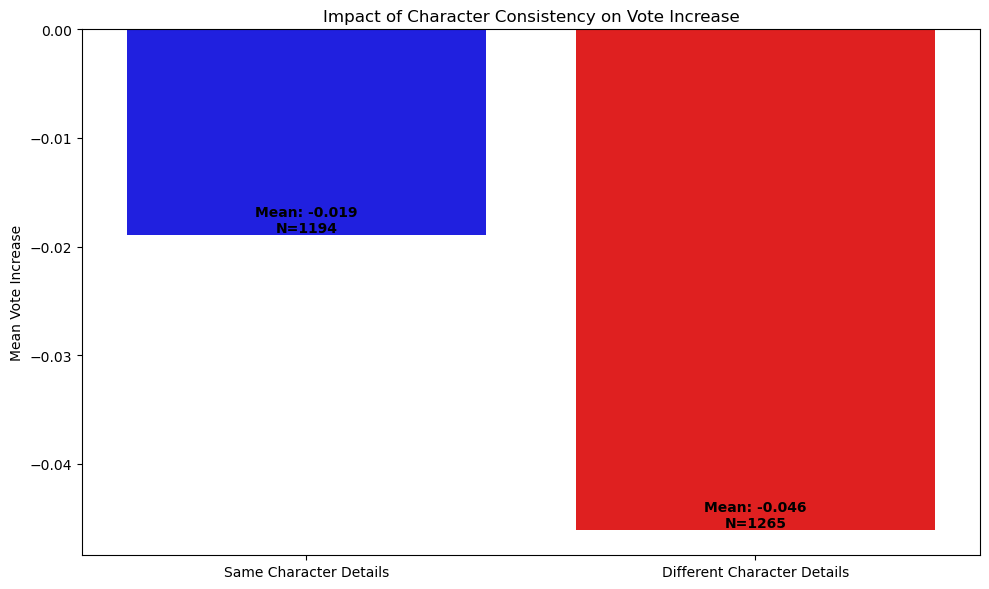

In [11]:

# Create a bar chart to visualize the difference
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Mean Vote Increase', data=comparison_df, palette=['blue', 'red'])
plt.title('Impact of Character Consistency on Vote Increase')
plt.ylabel('Mean Vote Increase')
plt.xlabel('')

# Add text annotations on bars
for i, row in enumerate(comparison_df.itertuples()):
    ax.text(i, row._2, f'Mean: {row._2:.3f}\nN={row._3}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

ในหนังที่มีมีการเปลี่ยนแปลงรายละเอียดตัวละครในภาคต่อ มีการเปลี่ยนแปลงการโหวดที่ดีขึ้นเฉลี่ย 7%
(เปลี่ยนแปลงตัวละครหลักไม่ได้ทำให้หนังแย่ลง)

### 5.2 วิเคราะห์ให้ลึกไปอีก ว่าการเปลี่ยนแปลงตัวละครแต่ละแบบส่งผลหรือไม่

#### 5.2.1 Visualization แสดงผลกระทบของความแตกต่างในตัวละครในภาคถัดไป

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

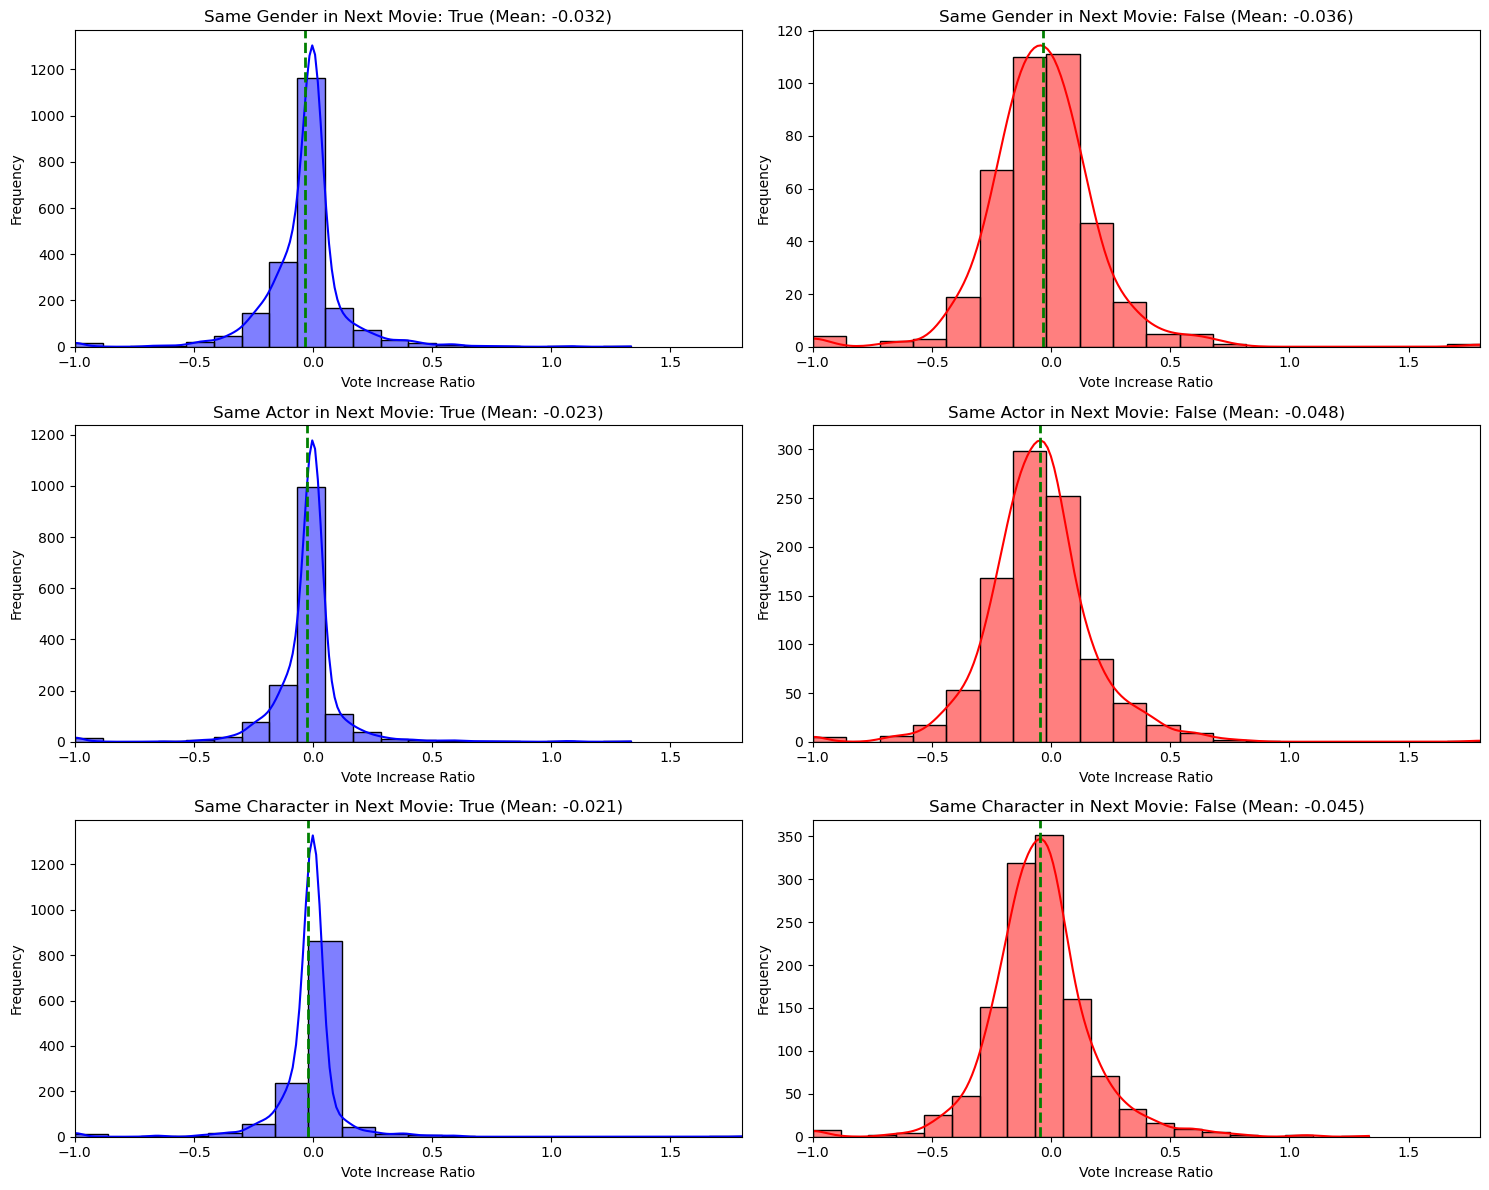

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Find global min and max for consistent x-axis limits
min_val = df_insight['vote_increase'].min()
max_val = df_insight['vote_increase'].max()

# next_main_cast_gender_same
# True
true_gender_data = df_insight[df_insight['next_main_cast_gender_same']==True]['vote_increase']
true_gender_mean = true_gender_data.mean()
sns.histplot(data=true_gender_data, kde=True, bins=20, ax=axes[0, 0], color='blue')
axes[0, 0].axvline(true_gender_mean, color='green', linestyle='--', linewidth=2)
axes[0, 0].set_title(f'Same Gender in Next Movie: True (Mean: {true_gender_mean:.3f})')
axes[0, 0].set_xlabel('Vote Increase Ratio')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(min_val, max_val)

# False
false_gender_data = df_insight[df_insight['next_main_cast_gender_same']==False]['vote_increase']
false_gender_mean = false_gender_data.mean()
sns.histplot(data=false_gender_data, kde=True, bins=20, ax=axes[0, 1], color='red')
axes[0, 1].axvline(false_gender_mean, color='green', linestyle='--', linewidth=2)
axes[0, 1].set_title(f'Same Gender in Next Movie: False (Mean: {false_gender_mean:.3f})')
axes[0, 1].set_xlabel('Vote Increase Ratio')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(min_val, max_val)

# next_main_cast_actor_name_same
# True
true_actor_data = df_insight[df_insight['next_main_cast_actor_name_same']==True]['vote_increase']
true_actor_mean = true_actor_data.mean()
sns.histplot(data=true_actor_data, kde=True, bins=20, ax=axes[1, 0], color='blue')
axes[1, 0].axvline(true_actor_mean, color='green', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'Same Actor in Next Movie: True (Mean: {true_actor_mean:.3f})')
axes[1, 0].set_xlabel('Vote Increase Ratio')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(min_val, max_val)

# False
false_actor_data = df_insight[df_insight['next_main_cast_actor_name_same']==False]['vote_increase']
false_actor_mean = false_actor_data.mean()
sns.histplot(data=false_actor_data, kde=True, bins=20, ax=axes[1, 1], color='red')
axes[1, 1].axvline(false_actor_mean, color='green', linestyle='--', linewidth=2)
axes[1, 1].set_title(f'Same Actor in Next Movie: False (Mean: {false_actor_mean:.3f})')
axes[1, 1].set_xlabel('Vote Increase Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(min_val, max_val)

# next_main_cast_same
# True
true_character_data = df_insight[df_insight['next_main_cast_same']==True]['vote_increase']
true_character_mean = true_character_data.mean()
sns.histplot(data=true_character_data, kde=True, bins=20, ax=axes[2, 0], color='blue')
axes[2, 0].axvline(true_character_mean, color='green', linestyle='--', linewidth=2)
axes[2, 0].set_title(f'Same Character in Next Movie: True (Mean: {true_character_mean:.3f})')
axes[2, 0].set_xlabel('Vote Increase Ratio')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_xlim(min_val, max_val)

# False
false_character_data = df_insight[df_insight['next_main_cast_same']==False]['vote_increase']
false_character_mean = false_character_data.mean()
sns.histplot(data=false_character_data, kde=True, bins=20, ax=axes[2, 1], color='red')
axes[2, 1].axvline(false_character_mean, color='green', linestyle='--', linewidth=2)
axes[2, 1].set_title(f'Same Character in Next Movie: False (Mean: {false_character_mean:.3f})')
axes[2, 1].set_xlabel('Vote Increase Ratio')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_xlim(min_val, max_val)

plt.tight_layout()
plt.show()



#### 5.2.2 สร้างตารางสรุปแต่ละประเภท

In [13]:
plot_data = {
    'Comparison': ['Gender', 'Gender', 'Actor', 'Actor', 'Character', 'Character'],
    'Same in Next Movie': ['True', 'False', 'True', 'False', 'True', 'False'],
    'Mean Vote Increase': [
        f'{true_gender_mean:.3f}', 
        f'{false_gender_mean:.3f}',
        f'{true_actor_mean:.3f}', 
        f'{false_actor_mean:.3f}',
        f'{true_character_mean:.3f}', 
        f'{false_character_mean:.3f}'
    ],
    'Sample Size': [
        f'{len(true_gender_data)}',
        f'{len(false_gender_data)}',
        f'{len(true_actor_data)}',
        f'{len(false_actor_data)}',
        f'{len(true_character_data)}',
        f'{len(false_character_data)}'
    ]
}

summary_df = pd.DataFrame(plot_data)
summary_df['Same in Next Movie'] = summary_df['Same in Next Movie'].map({'True': True, 'False': False})
summary_df['Sample Size'] = summary_df['Sample Size'].astype(int)
summary_df = summary_df.set_index(['Comparison', 'Same in Next Movie'])
summary_df = summary_df.sort_index()
summary_df

Mean Vote Increase  Sample Size
Comparison Same in Next Movie                                
Actor      False                          -0.048          954
           True                           -0.023         1505
Character  False                          -0.045         1208
           True                           -0.021         1251
Gender     False                          -0.036          392
           True                           -0.032         2067

การเปลี่ยนแปลงรายละเอียดตัวละครทุกแบบไม่ได้ทำให้คะแนนในภาคถัดไปลดลง และยังทำให้เพิ่มขึ้นด้วยซ้ำ ดังนั้นเราต้องวิเคราะห์ให้ลึกไปอีก

### 5.3 วิเคราะห์หนังที่มี vote เพิ่มในภาคถัดไป และลดในภาคภัดไป

#### 5.3.1 สร้างชุดที่เก็บ keyword และจำนวนของที่ Vote Increase เพิ่มขึ้น และ Vote Increase ลดลง

In [14]:
# Perform basic analysis to see if keywords affect vote increase
print("\nKeyword Analysis for Vote Increase:")

# Split data into two groups
vote_increase_df = interested[interested["vote_increase"] >= 0]
vote_decrease_df = interested[interested["vote_increase"] < 0]

print(f"Number of movies with increased votes: {len(vote_increase_df)}")
print(f"Number of movies with decreased votes: {len(vote_decrease_df)}")

# Get keyword columns
keyword_columns = [col for col in interested.columns if col.startswith('keyword_')]

# Calculate keyword frequencies for each group
increase_keywords = {}
decrease_keywords = {}

for col in keyword_columns:
    keyword = col[8:]  # Remove 'keyword_' prefix
    
    # Count occurrences in increased votes group
    increase_count = vote_increase_df[col].sum()
    if increase_count > 0:
        increase_keywords[keyword] = increase_count
    
    # Count occurrences in decreased votes group
    decrease_count = vote_decrease_df[col].sum()
    if decrease_count > 0:
        decrease_keywords[keyword] = decrease_count

# Create DataFrames for visualization
increase_df = pd.DataFrame(list(increase_keywords.items()), columns=['Keyword', 'Count'])
increase_df = increase_df.sort_values('Count', ascending=False)

decrease_df = pd.DataFrame(list(decrease_keywords.items()), columns=['Keyword', 'Count'])
decrease_df = decrease_df.sort_values('Count', ascending=False)


Keyword Analysis for Vote Increase:
Number of movies with increased votes: 1357
Number of movies with decreased votes: 1102


#### 5.3.2 แสดง Top 10 ของ หนังที่มี vote เพิ่มในภาคถัดไป และลดในภาคภัดไป

In [15]:
# Display top keywords for each group
print("\nTop 10 keywords in movies with increased votes:")
print(increase_df.head(10))

print("\nTop 10 keywords in movies with decreased votes:")
print(decrease_df.head(10))


Top 10 keywords in movies with increased votes:
             Keyword  Count
3285        violence     36
264   woman director     36
1315  based on novel     35
1120           anime     33
2093             sex     31
781           murder     31
161          vampire     30
3539           magic     30
3464    martial arts     29
2840       superhero     28

Top 10 keywords in movies with decreased votes:
               Keyword  Count
793             murder     54
3299          violence     43
3312           revenge     38
3475      martial arts     37
1307    based on novel     35
3267          dystopia     33
274     woman director     32
3388             blood     31
2137           monster     30
3127  independent film     29


### 5.4 เปลี่ยบเทียบความถี่ keyword แต่ละคำ ว่าอยู่ในที่เพิ่มขึ้นและลดลงในอัตราอย่างไร

#### 5.4.1 สร้างตารางเพื่อเปลี่ยบเทียบความถี่ keyword แต่ละคำ ว่าอยู่ในที่เพิ่มขึ้นและลดลงในอัตราเท่าไร

In [16]:
# Compare relative frequencies of top keywords between groups
top_keywords = pd.concat([
    increase_df.head(15)['Keyword'], 
    decrease_df.head(15)['Keyword']
]).unique()

comparison_data = []
for keyword in top_keywords:
    keyword_col = f'keyword_{keyword}'
    if keyword_col in interested.columns:
        # Calculate percentages
        increase_pct = vote_increase_df[keyword_col].mean() * 100
        decrease_pct = vote_decrease_df[keyword_col].mean() * 100
        
        comparison_data.append({
            'Keyword': keyword,
            'Increased Votes (%)': increase_pct,
            'Decreased Votes (%)': decrease_pct,
            'Difference': increase_pct - decrease_pct
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Difference', ascending=False)

print("\nComparison of keyword frequencies between groups:")
print(comparison_df)


Comparison of keyword frequencies between groups:
             Keyword  Increased Votes (%)  Decreased Votes (%)  Difference
3              anime             2.431835             1.361162    1.070673
6            vampire             2.210759             1.542650    0.668109
10        friendship             2.063375             1.542650    0.520725
9          superhero             2.063375             1.633394    0.429981
7              magic             2.210759             2.087114    0.123645
4                sex             2.284451             2.268603    0.015848
13     female nudity             1.842299             1.905626   -0.063327
11             sport             1.915991             1.996370   -0.080379
12           musical             1.842299             2.087114   -0.244815
1     woman director             2.652911             2.903811   -0.250900
21            nudity             1.694915             2.268603   -0.573687
2     based on novel             2.579219        

#### 5.4.2 สร้าง WordCloud เพื่อเปลี่ยบเทียบความถี่ keyword แต่ละคำ ว่าอยู่ในที่เพิ่มขึ้นและลดลงในอัตราเท่าไร

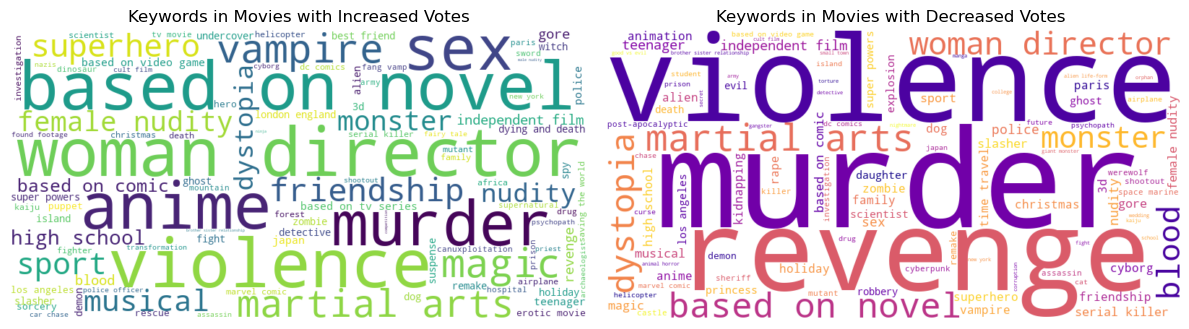

In [17]:
from wordcloud import WordCloud

plt.figure(figsize=(12, 5))

# Word cloud for increased votes
plt.subplot(1, 2, 1)
wordcloud_increase = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, colormap='viridis').generate_from_frequencies(increase_keywords)
plt.imshow(wordcloud_increase, interpolation='bilinear')
plt.title('Keywords in Movies with Increased Votes')
plt.axis('off')

# Word cloud for decreased votes
plt.subplot(1, 2, 2)
wordcloud_decrease = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, colormap='plasma').generate_from_frequencies(decrease_keywords)
plt.imshow(wordcloud_decrease, interpolation='bilinear')
plt.title('Keywords in Movies with Decreased Votes')
plt.axis('off')

plt.tight_layout()
plt.show()


จะเห็นว่ามีบาง keyword ที่พบบ่อยในหนังภาคต่อที่มี Vote ลดลง แต่ไม่พบในอันที่มีโหวดเพิ่มขึ้น
เช่น revenge, dystopia, murder และมีบางอันที่แทบไม่พบเลย เช่น Woman Director
เราจะใช้วิธีการสุ่มตัวอย่างและวิธีการทางสถิติเพื่อหา keyword ที่ถ้าพบแล้วหนังมักจะมีคะแนนลดลงหรือเพิ่มขึ้นน้อย โดยไม่ใช่เรื่องบังเอิญ อันมาจาก Distribution ของ keyword

#### 5.4.3 เปรียบเทียบ keyword ว่ามีผลต่อ Vote Increase ต่างกันเพียงใด

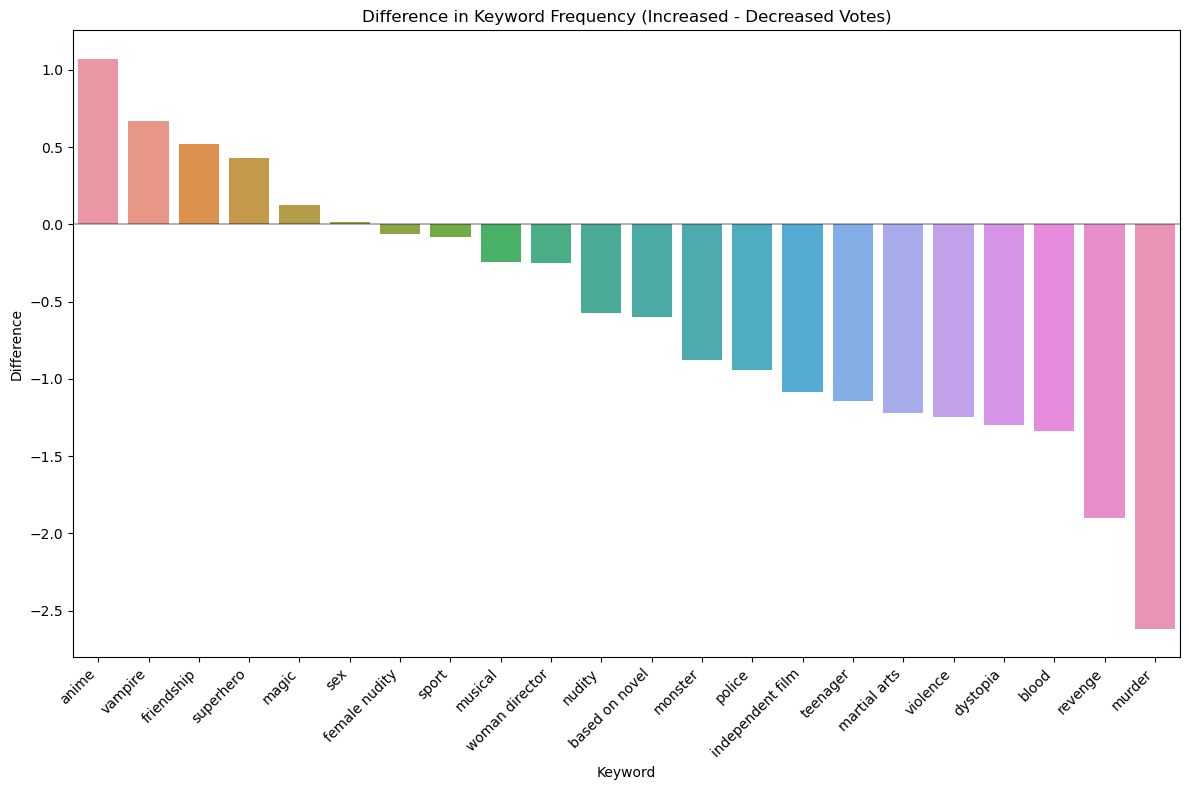

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Keyword', y='Difference', data=comparison_df)
plt.title('Difference in Keyword Frequency (Increased - Decreased Votes)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.5 ค้นพบข้อสังเกตที่นำไปสู่ Insight

keyword แบบไหนที่ทำให้ Vote ในภาคต่อไปมีคะแนนโหวดเพิ่มขึ้นน้อยลงหรือต่ำลงกว่า แบบที่ไม่มี keyword นี้

## 6. ใช้การสุ่ม และสถิติหาว่า keyword ใดส่งผลให้ vote_increase ลด มากที่สุด

### 6.1 เตรียมการดำเนินการ

#### 6.1.1 สร้าง DataFrame เพื่อเก็บ "หนัง" ที่มี word_increase เพิ่ม และ word_increase ลด

In [19]:
decreased_votes_df = interested[interested["vote_increase"] < 0]
increased_votes_df = interested[interested["vote_increase"] >= 0]


#### 6.1.2 หาว่ามี keyword ใดบ้าง โดยดูจากชื่อ column

In [20]:
# Create X (features) and y (target)
keyword_columns = [col for col in interested.columns if col.startswith('keyword_')]

#### 6.1.3 กรอง Keyword ที่มีจำนวนน้อยเกินไปออก (<10) และสร้าง y ซึ่งคือ Feature ที่สนใจว่า vote_increase จะลดหรือไม่

In [21]:
# Filter out rare keywords (occurring less than 5 times in total)
keyword_counts = interested[keyword_columns].sum()
frequent_keywords = keyword_counts[keyword_counts >= 10].index.tolist()

X = interested[frequent_keywords]
y = (interested["vote_increase"] < 0).astype(int) 

### 6.2 ดำเนินการ

#### 6.2.1 ตั้งสมมุติฐาน และออกแบบการทดลอง

- ทำการใช้ chi2 test ดูความ predictive ของ keyword นั้นส่งผลกับ vote_increase ไหม
- โดยทำการทดสอบ permutation_test กับทุก keyword ที่ทำให้ค่าเฉลี่ย vote_increase น้อยลง ว่าทำให้น้อยลงจริงๆไหม โดยตั้งสมมุติฐานดังนี้
- H0 : keyword ทำให้มี vote_increae น้อยลงเป็นเรื่องบังเอิญ
- H1 : keyword ทำให้มี vote_increae น้อยลงเป็นเรื่องไม่บังเอิญ
- ถ้ายอมรับ H1 เป็นจริง จะบันทึก keyword นั้น และค่า statistic ของ chi2 ไว้คู่กัน
- เรียงลำดับ keyword ที่ยอมรับ H1 จากค่า chi2 หรือความ predictive

ขั้นตอนสรุปโดยสังเขปดังนี้
1. แบ่งหนังตามคะแนน
2. นับ keyword
3. เลือก keyword ไม่พบบ่อยน้อยเกินไป     (ไม่ต่ำกว่า 10 ครั้ง)
4. หาคำที่สัมพันธ์กับการลดคะแนน โดยดูจากความ predictive ด้วย chi2
5. เรียงลำดับคำตามความสัมพันธ์
6. แสดงคำที่สำคัญที่สุด

#### 6.2.2 ดำเนินการ permutation_test และ chisquare

In [22]:
chi2_values, p_values = chi2(X, y)

permutation_results = {}

n_permutations = 1000

for i, col in enumerate(frequent_keywords):
    keyword = col[8:] 

    if decreased_votes_df[col].sum() > 0:
        decreased_pct = decreased_votes_df[col].sum() / len(decreased_votes_df)
        increased_pct = increased_votes_df[col].sum() / len(increased_votes_df) if len(increased_votes_df) > 0 else 0
        observed_diff = decreased_pct - increased_pct

        if observed_diff <= 0:
            continue

        permutation_diffs = []
        combined_data = interested[col].values
        combined_labels = y.values
        
        for _ in range(n_permutations):
            shuffled_labels = shuffle(combined_labels)
            
            perm_decreased = combined_data[shuffled_labels == 1]
            perm_increased = combined_data[shuffled_labels == 0]
            
            perm_decreased_pct = np.mean(perm_decreased) if len(perm_decreased) > 0 else 0
            perm_increased_pct = np.mean(perm_increased) if len(perm_increased) > 0 else 0
            
            permutation_diffs.append(perm_decreased_pct - perm_increased_pct)
        
        # proportion of permutations with diff >= observed)
        p_value = np.mean([diff >= observed_diff for diff in permutation_diffs])
        
        if p_value < ALPHA: 
            ratio = decreased_pct / increased_pct if increased_pct > 0 else float('inf')
            permutation_results[keyword] = {
                'chi2': chi2_values[i],
                'diff' : observed_diff,
                'p_value': p_value,
                'ratio': ratio,
                'decreased_pct': decreased_pct * 100,
                'increased_pct': increased_pct * 100,
                'count': keyword_counts[col]
            }

#### 6.2.3 สร้าง word_cloud โดยใช้ความ predictive เป็น weight 
- หรือก็คือ keyword ที่มีความสามารถในการ predictive การลด vote increase จะมีน้ำหนักมาก

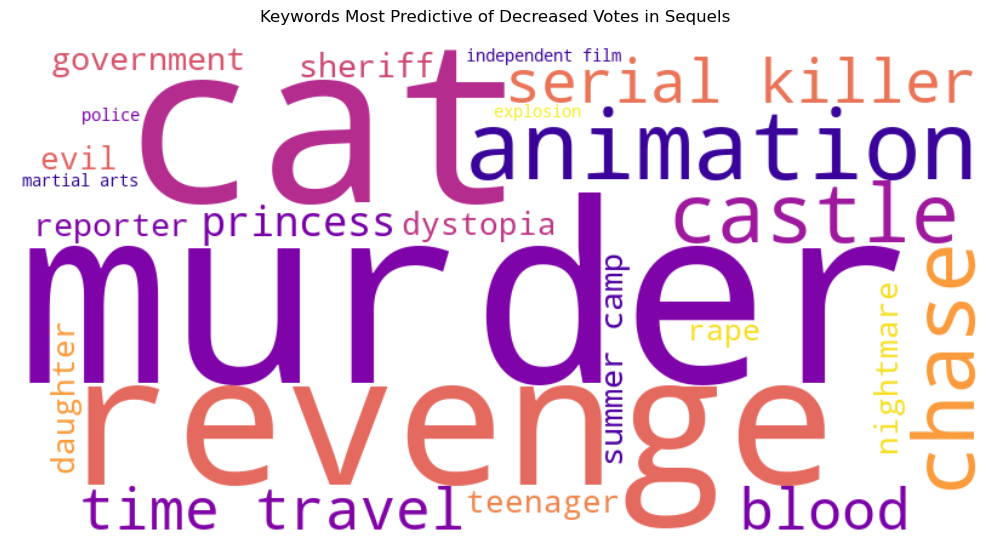

In [23]:
# sort by chi2 value
sorted_keywords = {k: v for k, v in sorted(permutation_results.items(), 
                                          key=lambda item: item[1]['chi2'], 
                                          reverse=True)}

wordcloud_dict = {k: v['chi2'] for k, v in sorted_keywords.items()}

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                        max_words=100, colormap='plasma').generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords Most Predictive of Decreased Votes in Sequels\n')
plt.tight_layout()
plt.show()


#### 6.2.4 คำสำคัญที่ทำนายการลดลงของคะแนนโหวตในภาคต่อได้มากที่สุด:

In [24]:
for i, (keyword, stats_dict) in enumerate(list(sorted_keywords.items())[:10]):
    print(f"{i+1}. {keyword}: {stats_dict['decreased_pct']:.2f}% ในกลุ่มที่คะแนนลดลง vs "
            f"{stats_dict['increased_pct']:.2f}% ในกลุ่มที่คะแนนเพิ่มขึ้น "
            f"(อัตราส่วน: {stats_dict['ratio']:.2f}, ค่า p-value: {stats_dict['p_value']:.4f}, "
            f"จำนวนที่พบทั้งหมด: {stats_dict['count']})")

1. murder: 4.90% ในกลุ่มที่คะแนนลดลง vs 2.28% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 2.15, ค่า p-value: 0.0000, จำนวนที่พบทั้งหมด: 85)
2. cat: 0.91% ในกลุ่มที่คะแนนลดลง vs 0.07% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 12.31, ค่า p-value: 0.0000, จำนวนที่พบทั้งหมด: 11)
3. revenge: 3.45% ในกลุ่มที่คะแนนลดลง vs 1.55% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 2.23, ค่า p-value: 0.0000, จำนวนที่พบทั้งหมด: 59)
4. animation: 1.45% ในกลุ่มที่คะแนนลดลง vs 0.37% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 3.94, ค่า p-value: 0.0010, จำนวนที่พบทั้งหมด: 21)
5. chase: 1.00% ในกลุ่มที่คะแนนลดลง vs 0.22% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 4.52, ค่า p-value: 0.0080, จำนวนที่พบทั้งหมด: 14)
6. castle: 1.09% ในกลุ่มที่คะแนนลดลง vs 0.29% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 3.69, ค่า p-value: 0.0190, จำนวนที่พบทั้งหมด: 16)
7. serial killer: 2.00% ในกลุ่มที่คะแนนลดลง vs 0.88% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 2.26, ค่า p-value: 0.0120, จำนวนที่พบทั้งหมด: 34)
8. time travel: 1.54% ในกลุ่มที่คะแนนลดลง vs 0.59% ในกลุ่มที่

### 6.3 หาค่า Confidence Interval ที่ 95% ของ ค่าเฉลี่ยของความแตกต่างละหว่างการลดลงของ Vote Increase ในหนังที่มี keyword กับหนังที่ไม่มี keyword นั้น

#### 6.3.1 แบ่งชุดข้อมูลที่มี keyword นั้นกับที่ไม่มี

In [25]:
list(sorted_keywords.keys())
# find the row that contain one of the keyword
# Let's find examples of movies that contain the top predictive keywords
top_keywords = list(sorted_keywords.keys())[:15]  # Get top 15 keywords
nt = []
for k in top_keywords:
    nt.append("keyword_"+k)

def contains_top_keyword(row):
    return sum(row[nt]) != 0

contain_keyword = interested[interested.apply(lambda x: contains_top_keyword(x), axis=1)]
not_contain_keyword = interested[interested.apply(lambda x: not contains_top_keyword(x), axis=1)]


In [26]:
mean_with_keywords = contain_keyword["vote_increase"].mean()
mean_without_keywords = not_contain_keyword["vote_increase"].mean()
difference = mean_with_keywords - mean_without_keywords
pct = mean_with_keywords/mean_without_keywords*100

In [27]:
print(f"{top_keywords}")
print(f"หนังที่มี keyword เหล่านี้ในภาคต่อไปมักจะมีคะแนนต่ำกว่าหนังที่ไม่มี keyword เหล่านี้ {pct:.2f}%")

['murder', 'cat', 'revenge', 'animation', 'chase', 'castle', 'serial killer', 'time travel', 'blood', 'princess', 'government', 'summer camp', 'reporter', 'sheriff', 'dystopia']
หนังที่มี keyword เหล่านี้ในภาคต่อไปมักจะมีคะแนนต่ำกว่าหนังที่ไม่มี keyword เหล่านี้ 234.15%


#### 6.3.2 Visualize Impact ของการมี keyword เหล่่านี้ หรือการไม่มี

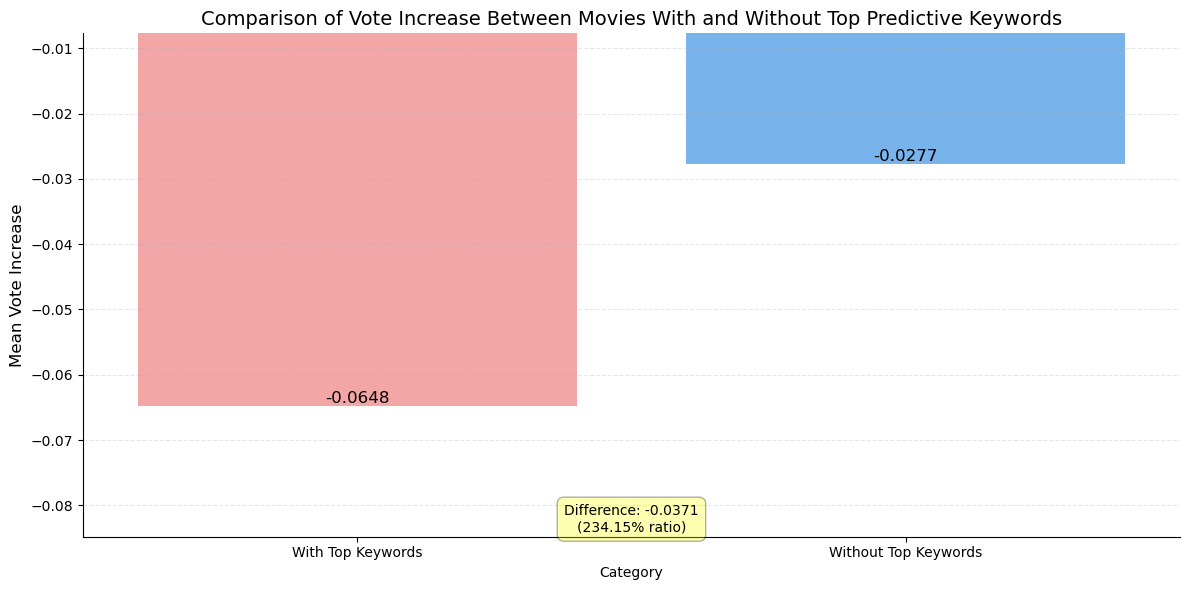

In [28]:
# Prepare data for seaborn
comparison_data = pd.DataFrame({
    'Category': ['With Top Keywords', 'Without Top Keywords'],
    'Mean Vote Increase': [mean_with_keywords, mean_without_keywords]
})

# Create the bar chart with seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Category', y='Mean Vote Increase', data=comparison_data, palette=['#ff9999', '#66b3ff'])

# Add data labels on top of the bars
for i, v in enumerate(comparison_data['Mean Vote Increase']):
    ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12)

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Add title and labels
plt.title('Comparison of Vote Increase Between Movies With and Without Top Predictive Keywords', fontsize=14)
plt.ylabel('Mean Vote Increase', fontsize=12)
plt.ylim(min(comparison_data['Mean Vote Increase']) - 0.02, max(comparison_data['Mean Vote Increase']) + 0.02)

# Add annotation about the difference
plt.annotate(f'Difference: {difference:.4f}\n({pct:.2f}% ratio)',
             xy=(0.5, min(comparison_data['Mean Vote Increase']) - 0.01),
             xytext=(0.5, min(comparison_data['Mean Vote Increase']) - 0.015),
             ha='center', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

# Add styling
sns.despine(left=False, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### 6.3.3 หา CI ที่ 95% ของความแตกต่างระหว่างการมีกับไม่มี keyword นั้น

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


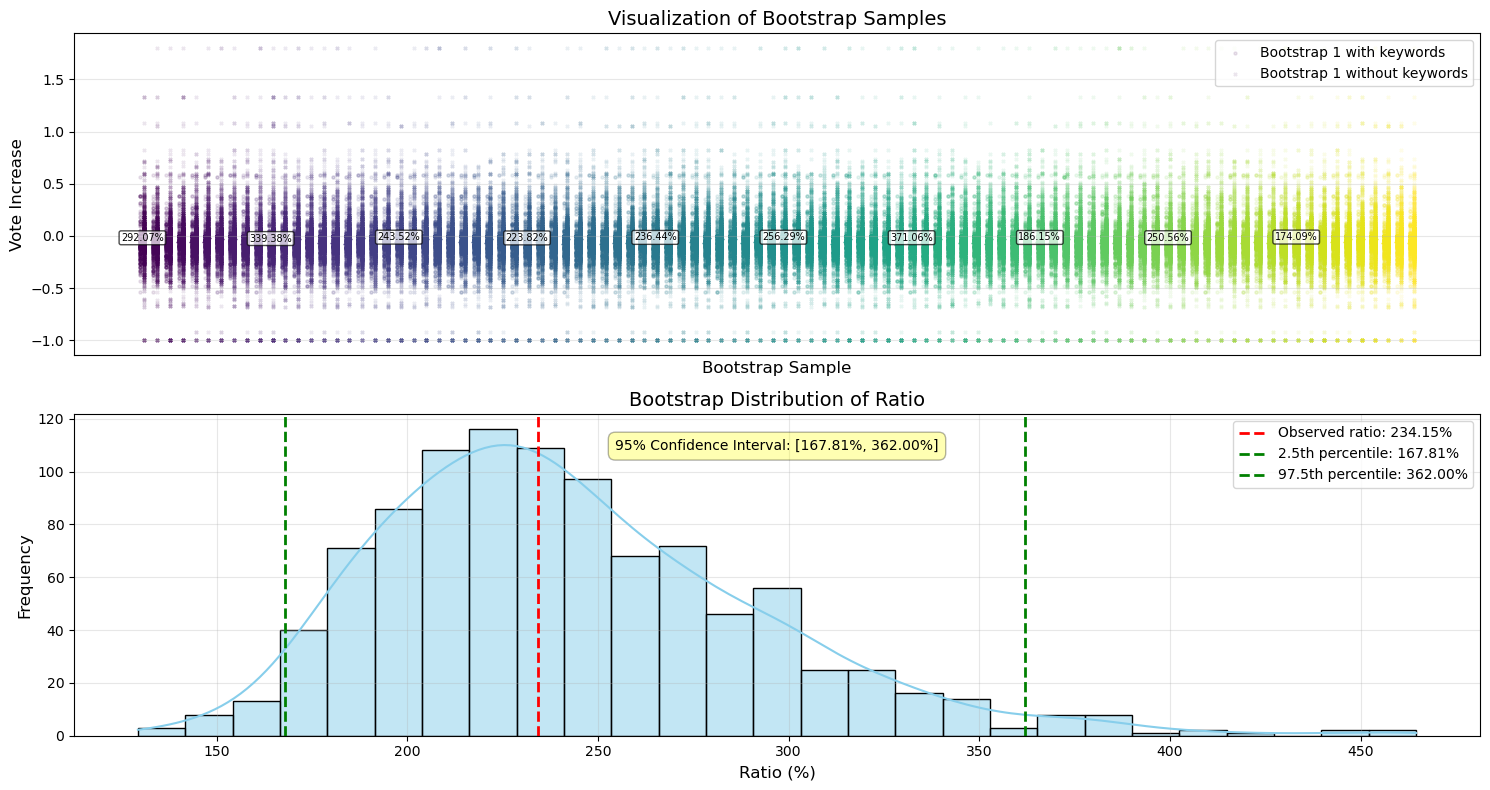

In [29]:
# Calculate confidence interval for the ratio (pct) using bootstrap sampling
n_bootstrap = 1000
bootstrap_ratios = []

np.random.seed(42)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
sample_to_show = 100
colors = plt.cm.viridis(np.linspace(0, 1, sample_to_show))

for i in range(n_bootstrap):
    sample_with = contain_keyword.sample(len(contain_keyword), replace=True)["vote_increase"]
    sample_without = not_contain_keyword.sample(len(not_contain_keyword), replace=True)["vote_increase"]

    mean_with_sample = sample_with.mean()
    mean_without_sample = sample_without.mean()

    ratio = mean_with_sample / mean_without_sample * 100
    bootstrap_ratios.append(ratio)

    if i < sample_to_show:
        plt.scatter(np.ones(len(sample_with)) * (i+1), sample_with, 
                   alpha=0.1, color=colors[i], s=5, label=f'Bootstrap {i+1} with keywords' if i == 0 else "")
        plt.scatter(np.ones(len(sample_without)) * (i+1.3), sample_without, 
                   alpha=0.1, color=colors[i], marker='x', s=5, label=f'Bootstrap {i+1} without keywords' if i == 0 else "")

        plt.hlines(mean_with_sample, i+0.8, i+1.2, colors=colors[i], linewidth=1)
        plt.hlines(mean_without_sample, i+1.1, i+1.5, colors=colors[i], linewidth=1, linestyle='--')

        if i % 10 == 0:
            plt.text(i+1.15, (mean_with_sample + mean_without_sample)/2, 
                    f'{ratio:.2f}%', fontsize=7, ha='center', 
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

plt.title('Visualization of Bootstrap Samples', fontsize=14)
plt.ylabel('Vote Increase', fontsize=12)
plt.xlabel('Bootstrap Sample', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks([])
plt.legend()

plt.subplot(2, 1, 2)
bootstrap_ratios = np.array(bootstrap_ratios)

lower_ci = np.percentile(bootstrap_ratios, 2.5)
upper_ci = np.percentile(bootstrap_ratios, 97.5)

sns.histplot(bootstrap_ratios, kde=True, color='skyblue')
plt.axvline(pct, color='red', linestyle='dashed', linewidth=2, label=f'Observed ratio: {pct:.2f}%')
plt.axvline(lower_ci, color='green', linestyle='dashed', linewidth=2, label=f'2.5th percentile: {lower_ci:.2f}%')
plt.axvline(upper_ci, color='green', linestyle='dashed', linewidth=2, label=f'97.5th percentile: {upper_ci:.2f}%')

plt.title('Bootstrap Distribution of Ratio', fontsize=14)
plt.xlabel('Ratio (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

plt.annotate(f'95% Confidence Interval: [{lower_ci:.2f}%, {upper_ci:.2f}%]',
             xy=(0.5, 0.9), xycoords='axes fraction',
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

## 7. ทดสอบสมมุติฐานที่ได้ในขั้นตอนที่แล้วว่า
- H0 (สมมติฐานหลัก): 
    - การที่พบว่า ภาพยนตร์ที่มี keyword เหล่านั้น มีแนวโน้มที่จะมีคะแนนเพิ่มขึ้นในภาคถัดไป น้อยกว่า ภาพยนตร์ที่ไม่มี keyword เหล่านั้น โดยเฉลี่ย 0.0371 (ต่างกัน 234.15%) เป็นเรื่องบังเอิญ
- H1 (สมมติฐานทางเลือก): 
    - ภาพยนตร์ที่มี keyword เหล่านั้น มีแนวโน้มที่จะมีคะแนนเพิ่มขึ้นในภาคถัดไป น้อยกว่า ภาพยนตร์ที่ไม่มี keyword เหล่านั้น โดยเฉลี่ย 0.0371 (ต่างกัน 234.15%)

### 7.1 ดำเนินการหาโดยใช้ bootstrap

In [30]:
# Perform bootstrap test to see if movies with these keywords have significantly lower vote increases
n_bootstrap = 1000
observed_diff = contain_keyword["vote_increase"].mean() - not_contain_keyword["vote_increase"].mean()
print(observed_diff)
# Bootstrap sampling
bootstrap_diffs = []
for _ in range(n_bootstrap):
    # Resample with replacement from each group
    #sample_with = np.random.choice(interested["vote_increase"], size=len(contain_keyword))
    sample_with = interested.sample(len(contain_keyword))["vote_increase"]
    sample_without = interested.drop(contain_keyword.index)["vote_increase"]
    
    # Calculate the difference in means for this bootstrap sample
    bootstrap_diff = np.mean(sample_with) - np.mean(sample_without)
    bootstrap_diffs.append(bootstrap_diff)

# Calculate p-value (proportion of bootstrap samples with difference >= observed_diff)
# For a one-sided test (less than), we count how many bootstrap differences are <= observed_diff
p_value = np.mean(np.array(bootstrap_diffs) <= observed_diff)


print(f"ผลการทดสอบ Bootstrap (n={n_bootstrap}):")
print(f"ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: {observed_diff:.4f}")
print(f"ที่ CI 95% สำหรับความแตกต่าง: [{np.percentile(bootstrap_diffs, 2.5):.4f}, {np.percentile(bootstrap_diffs, 97.5):.4f}]")
print(f"ค่า p-value (การทดสอบทางเดียว): {p_value:.6f}")

if p_value < ALPHA:
    print(f"ผลลัพธ์มีนัยสำคัญทางสถิติ (p < {ALPHA}).")
    print(f"ภาพยนตร์ที่มี keyword เหล่านี้มีการเพิ่มขึ้นของคะแนนโหวตต่ำกว่าภาพยนตร์ที่ไม่มี keyword เหล่านี้อย่างมีนัยสำคัญ")
    
    # Calculate the mean difference
    print(f"ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่มี keyword: {mean_with_keywords:.4f}")
    print(f"ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่ไม่มี keyword: {mean_without_keywords:.4f}")
    print(f"ความแตกต่าง: {pct:.4f}%")
else:
    print(f"ผลลัพธ์ไม่มีนัยสำคัญทางสถิติ (p >= {ALPHA}).")

-0.03713769370120137
ผลการทดสอบ Bootstrap (n=1000):
ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: -0.0371
ที่ CI 95% สำหรับความแตกต่าง: [-0.0232, 0.0123]
ค่า p-value (การทดสอบทางเดียว): 0.000000
ผลลัพธ์มีนัยสำคัญทางสถิติ (p < 0.05).
ภาพยนตร์ที่มี keyword เหล่านี้มีการเพิ่มขึ้นของคะแนนโหวตต่ำกว่าภาพยนตร์ที่ไม่มี keyword เหล่านี้อย่างมีนัยสำคัญ
ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่มี keyword: -0.0648
ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่ไม่มี keyword: -0.0277
ความแตกต่าง: 234.1542%


### 7.2 แสดงค่า p-value

C:\Users\sunmodza\AppData\Local\Temp\ipykernel_7896\3782972546.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bootstrap_diffs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


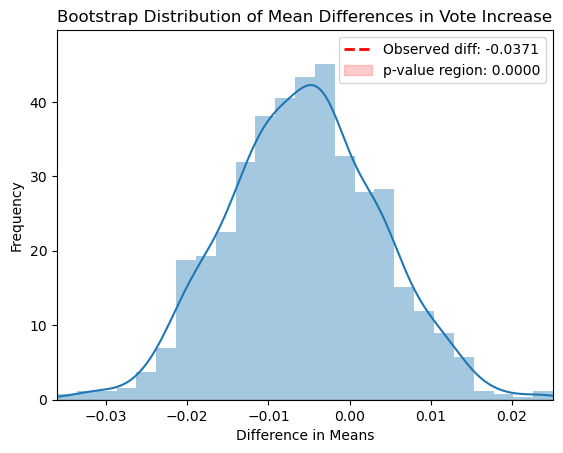

In [31]:
sns.distplot(bootstrap_diffs)
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2, label=f'Observed diff: {observed_diff:.4f}')
plt.title('Bootstrap Distribution of Mean Differences in Vote Increase')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')

# Highlight the p-value area on the plot
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)  # Add a horizontal line at y=0 for reference

# Calculate the 5% threshold for highlighting
threshold_index = int(0.05 * len(bootstrap_diffs))
sorted_diffs = np.sort(bootstrap_diffs)
threshold_value = sorted_diffs[threshold_index]

# Highlight the area representing the p-value
plt.fill_between(
    np.linspace(-9, observed_diff, 100),
    0, 
    plt.gca().get_ylim()[1],
    color='red', 
    alpha=0.2,
    label=f'p-value region: {p_value:.4f}'
)
plt.xlim(min(bootstrap_diffs),max(bootstrap_diffs))

plt.legend()

### 7.4 สรุปสมมุติฐาน

หา P-value ได้ 0 ความน่าจะเป็น H0 เป็น 0 ซึ่งน้อยกว่า Alpha จึงปฏิเสธ H0 และยอมรับ H1 จึงสรุปได้ว่า

“พบว่า Movie ที่มี keyword เหล่านี้ มักจะมีคะแนนเพิ่มขึ้น ในภาคต่อไปน้อยกว่าถึง 234.15% เทียบกับ Movie ที่ไม่มี keyword เหล่านี้”

### (เสริม) ทดสอบว่าหากมี keyword นี้กับไม่มี keyword จะมีความแตกต่างของ vote average ในภาคปัจจุบันไหม

0.17550120605258712


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


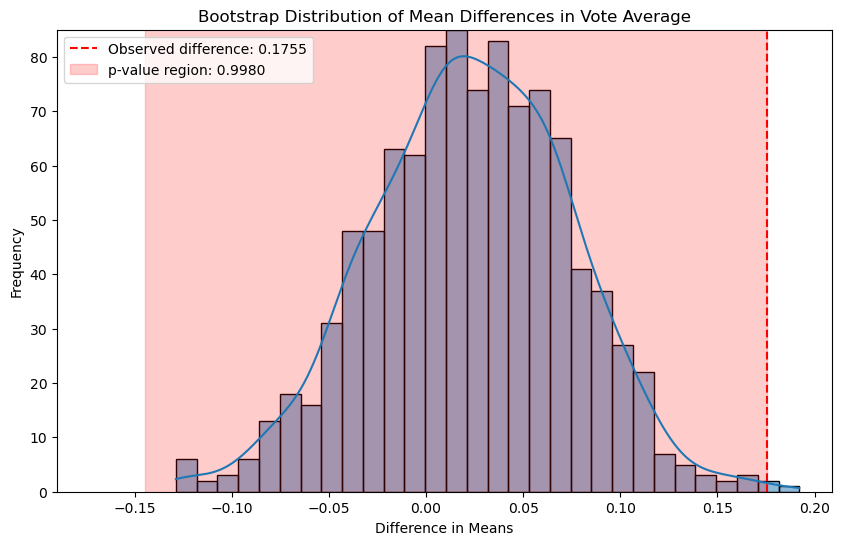

ผลการทดสอบ Bootstrap (n=1000):
ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: 0.1755
ที่ CI 95% สำหรับความแตกต่าง: [-0.0791, 0.1163]
ค่า p-value (การทดสอบทางเดียว): 0.998000
ผลลัพธ์ไม่มีนัยสำคัญทางสถิติ (p >= 0.05).
ยอมรับ H0 ว่า
การที่ภาพยนตร์ที่มีคำสำคัญเหล่านี้มีคะแนนโหวตน้อยกว่าจากหนังที่ไม่มี keyword เหล่านี้ เป็นเรื่องบังเอิญ


In [32]:
n_bootstrap = 1000
observed_diff = contain_keyword["vote_average"].mean() - not_contain_keyword["vote_average"].mean()
print(observed_diff)

bootstrap_diffs = []
for _ in range(n_bootstrap):
    sample_with = interested.sample(len(contain_keyword))["vote_average"]
    sample_without = interested.drop(contain_keyword.index)["vote_average"]

    bootstrap_diff = np.mean(sample_with) - np.mean(sample_without)
    bootstrap_diffs.append(bootstrap_diff)

p_value = np.mean(np.array(bootstrap_diffs) <= observed_diff)

mean_with_keywords = contain_keyword["vote_average"].mean()
mean_without_keywords = not_contain_keyword["vote_average"].mean()
pct = (mean_with_keywords - mean_without_keywords) / mean_without_keywords * 100

plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_diffs, bins=30, kde=True)
plt.axvline(observed_diff, color='red', linestyle='--', 
            label=f'Observed difference: {observed_diff:.4f}')

plt.fill_between(
    np.linspace(plt.gca().get_xlim()[0], observed_diff, 100),
    0, 
    plt.gca().get_ylim()[1],
    color='red', 
    alpha=0.2,
    label=f'p-value region: {p_value:.4f}'
)
plt.ylim(0,85)
plt.xlim(-0.19)
plt.title('Bootstrap Distribution of Mean Differences in Vote Average')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()
plt.show()


print(f"ผลการทดสอบ Bootstrap (n={n_bootstrap}):")
print(f"ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: {observed_diff:.4f}")
print(f"ที่ CI 95% สำหรับความแตกต่าง: [{np.percentile(bootstrap_diffs, 2.5):.4f}, {np.percentile(bootstrap_diffs, 97.5):.4f}]")
print(f"ค่า p-value (การทดสอบทางเดียว): {p_value:.6f}")

if p_value < ALPHA:
    print(f"ผลลัพธ์มีนัยสำคัญทางสถิติ (p < {ALPHA}).")
    print(f"ภาพยนตร์ที่มีคำสำคัญเหล่านี้มีคะแนนโหวตต่ำกว่าภาพยนตร์ที่ไม่มี keyword เหล่านี้อย่างมีนัยสำคัญ")

    print(f"ค่าเฉลี่ยคะแนนโหวตที่มี keyword: {mean_with_keywords:.4f}")
    print(f"ค่าเฉลี่ยงคะแนนโหวตที่ไม่มี keyword: {mean_without_keywords:.4f}")
    print(f"ความแตกต่าง: {pct:.4f}%")
else:
    print(f"ผลลัพธ์ไม่มีนัยสำคัญทางสถิติ (p >= {ALPHA}).")
    print(f"ยอมรับ H0 ว่า")
    print("การที่ภาพยนตร์ที่มีคำสำคัญเหล่านี้มีคะแนนโหวตน้อยกว่าจากหนังที่ไม่มี keyword เหล่านี้ เป็นเรื่องบังเอิญ")



## สรุปผลการค้นหา Insight

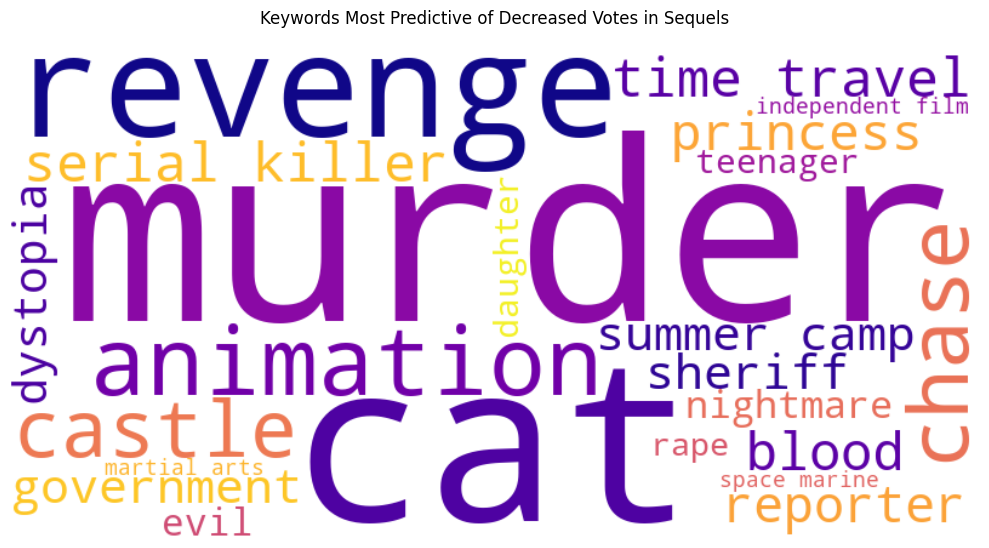

### 1. พบว่า Movie ที่มี keyword เหล่านี้ มักจะมีคะแนนเพิ่มขึ้น ในภาคต่อไปน้อยกว่าถึง 234.15% เทียบกับ Movie ที่ไม่มี keyword เหล่านี้ 
### 2. แม้ keyword เหล่านี้ จะมีผลให้หนังภาคต่อไป มี vote ต่ำลง แต่กลับไม่มีผลทำให้คะแนน vote ปัจจุบัน แตกต่างเลย